In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functools 
import fun_eda

In [3]:
import math
from itertools import product
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import tree

In [4]:
def vizs(df, df_scaled, kmeans_clusters, best_estimator, X, y, per):
    fig = plt.figure(figsize=(9, 5))
    grid = plt.GridSpec(1,2)
    ax1 = fig.add_subplot(grid[0])
    ax2 = fig.add_subplot(grid[1])
    #ax3 = fig.add_subplot(grid[1, :])
    sns.set_style("darkgrid")
        
    ##### Visualizacion K-means
    PERPLEXITY=per
    tsne = TSNE(n_components=2, perplexity= PERPLEXITY)
    tsne_components = tsne.fit_transform(df_scaled)
    TSNE_df = pd.DataFrame(tsne_components)
    TSNE_df.insert(0, 'cluster', kmeans_clusters)

    n=len(set(kmeans_clusters))
    datas = [[TSNE_df[TSNE_df['cluster']==i][j] for j in range(2)] for i in list(set(kmeans_clusters))]
    colors =  ('green', 'red', 'blue', 'yellow', 'purple')
    groups = [str(i) for i in list(set(kmeans_clusters))]
    
    for data, group, color in zip(datas, groups, colors):
        #print(len(data), len(color), len(group))
        # cmap=plt.get_cmap('viridis')
        ax1.scatter(data[0], data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax1.set_title(f'clusters:{n}')
        ax1.legend()
    
    ##### Visualizacion relevancia de variables
    clf_best = best_estimator
    clf_best.fit(X, y)
    feature_imp = pd.Series(clf_best.feature_importances_, index=df.columns).sort_values(ascending=False)

    #pp = sns.cubehelix_palette(30, start=.1, rot=-.75, reverse=True)
    #sns.barplot(x=feature_imp, y=feature_imp.index, palette=pp, ax=ax1)
    #ax3.set_title("Vizualizacion del score de importancia de las variables")
    
    ##### Visualizacion del arbol
    ax2 = tree.plot_tree(clf_best,
               feature_names=df.columns.to_list(),  
               #class_names=["C0","C1", "C2"],
               filled=True)
    
    plt.show()
    return feature_imp

### 1. Carga de la información

In [5]:
cwd = os.getcwd()

In [6]:
PATH_ORIGEN = os.path.join(cwd, "data/rutas_tiles/agebs_de_origen_demograficos.csv")
ageb_origen = pd.read_csv(PATH_ORIGEN)
ageb_origen = ageb_origen.add_suffix("_origen")
print("origen", ageb_origen.shape)

PATH_DESTINO = os.path.join(cwd, "data/rutas_tiles/agebs_de_destino_demograficos.csv")
ageb_destino = pd.read_csv(PATH_DESTINO)
ageb_destino = ageb_destino.add_suffix("_destino")
print("destino", ageb_destino.shape)

origen (506, 214)
destino (506, 214)


In [7]:
ageb_data_all = ageb_origen.merge(ageb_destino, right_on='geometry_destino', left_on='geometry_origen', how='left')
ageb_data_all.drop(columns=['X1.x_origen'],inplace=True)
print(ageb_data_all.shape)
ageb_data_all.head(5)

(510, 427)


,geometry_origen,start_polygon_name_origen,end_polygon_name_origen,long_o_origen,lat_o_origen,long_d_origen,lat_d_origen,id_ageb_ent_origen_origen,CVE_AGEB_origen_origen,id_origen_origen,...,VPH_SNBIEN_destino,VPH_RADIO_destino,VPH_TV_destino,VPH_REFRI_destino,VPH_LAVAD_destino,VPH_AUTOM_destino,VPH_PC_destino,VPH_TELEF_destino,VPH_CEL_destino,VPH_INTER_destino
0,"(-98.756103515625 19.714999913710088, -98.7561...",Axapusco,Otumba,-98.75610,19.71500,-98.75610,19.69431,150650105,105,622,...,0,159,166,138,114,68,55,37,126,25
1,"(-98.800048828125 19.21780263228372, -98.80004...",Chalco,Tlalmanalco,-98.80005,19.21780,-98.80005,19.19705,150251606,1606,217,...,3,1004,1057,894,791,411,364,479,843,259
2,"(-98.82202148437499 19.69431390762537, -98.843...",San Martín de las Pirámides,Teotihuacán,-98.82202,19.69431,-98.84399,19.69431,15075014A,014A,501,...,5,459,487,423,326,206,164,218,379,117
3,"(-98.84399414062499 19.280035468000158, -98.84...",Chalco,Ixtapaluca,-98.84399,19.28004,-98.84399,19.30077,150391601,1601,570,...,4,2271,2447,2313,1943,897,948,1563,1959,637
4,"(-98.84399414062501 19.259293812482564, -98.86...",Chalco,Chalco,-98.84399,19.25929,-98.86597,19.25929,150250044,44,652,...,0,14,15,13,10,5,6,12,9,3


In [8]:
##### Load datos de unidades economicas y rezago social por ageb
DATOS_UE_AGEB = os.path.join(cwd, "data/table_3_por_ageb.pkl")
ageb_dataUE = pd.read_pickle(DATOS_UE_AGEB) 
ageb_dataUE['_ageb'] = ageb_dataUE['cve_ent'] + ageb_dataUE['cve_mun'] + ageb_dataUE['ageb']
ageb_dataUE.drop(columns=['ageb_long','cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc', 'localidad', 'ageb', 'ageb_9_dig','Clave_de_AGEB'], inplace=True)

ageb_dataUE.rename(columns={'Generacion,_transmision,_distribucion_y_comercializacion_de_energia_electrica,_suministro_de_agua_y_de_gas_natural_por_ductos_al_consumidor_final':'Electricidad',
                          'Servicios_de_alojamiento_temporal_y_de_preparacion_de_alimentos_y_bebidas':'Alimentos_y_bebidas',
                          'Servicios_de_apoyo_a_los_negocios_y_manejo_de_residuos,_y_servicios_de_remediacion':'Manejo_residuos',
                          'Servicios_de_esparcimiento_culturales_y_deportivos,_y_otros_servicios_recreativos':'Esparcimiento',
                          'Servicios_inmobiliarios_y_de_alquiler_de_bienes_muebles_e_intangibles':'Inmobiliarios_y_bienes_muebles', 
                          'Agricultura,_cria_y_explotacion_de_animales,_aprovechamiento_forestal,_pesca_y_caza':'Agricultura',
                          'Otros_servicios_excepto_actividades_gubernamentales':'Otros_servicios',
                          'Servicios_profesionales,_cientificos_y_tecnicos':'Servicios_profesionales_tecnicos'}, inplace=True)

ageb_dataUE.columns = [ 'ue_'+x for x in ageb_dataUE.columns]
ageb_dataUE['ue_totales'] = ageb_dataUE.iloc[:,0:19].sum(axis=1)
ageb_dataUE.rename(columns={'ue_Rango_de_pobreza_(%)':'Rango_de_pobreza_(%)',
                            'ue_Rango_de_pobreza_extrema_(%)':'Rango_de_pobreza_extrema_(%)' }, inplace=True)
# Pobreza
ageb_dataUE['Rango_de_pobreza_(%)'] = ageb_dataUE['Rango_de_pobreza_(%)'].map({'[ 0, 18]':"C1", 
                                                                               '(18, 34]':"C2", 
                                                                               '(34, 50]':"C3" , 
                                                                               '(50, 70]':"C4", 
                                                                               '(70, 100]':"C5", 
                                                                               'Una vivienda particular habitada':"C0",
                                                                               'Sin viviendas particulares habitadas':"C0"},
                                                                               na_action="C0")
ageb_dataUE.loc[ageb_dataUE['Rango_de_pobreza_(%)'].isnull(), 'Rango_de_pobreza_(%)'] = "C0"

#ageb_dataUE.drop_duplicates(keep='first', inplace=True)
print("Info UE y rezago por AGEB:", ageb_dataUE.shape)
ageb_dataUE.head(5)

Info UE y rezago por AGEB: (7409, 23)


,ue_Agricultura,ue_Comercio_al_por_mayor,ue_Comercio_al_por_menor,ue_Construccion,ue_Corporativos,ue_Electricidad,ue_Industrias_manufactureras,ue_Informacion_en_medios_masivos,ue_Mineria,ue_Otros_servicios,...,ue_Servicios_de_salud_y_de_asistencia_social,ue_Servicios_educativos,ue_Servicios_financieros_y_de_seguros,ue_Inmobiliarios_y_bienes_muebles,ue_Servicios_profesionales_tecnicos,"ue_Transportes,_correos_y_almacenamiento",Rango_de_pobreza_(%),Rango_de_pobreza_extrema_(%),ue__ageb,ue_totales
0,0,2,68,0,0,0,14,0,0,26,...,14,5,1,1,5,0,C2,"[ 0, 20]",090020010,168
1,0,0,37,0,0,0,1,1,0,2,...,2,3,0,1,0,0,C1,"[ 0, 20]",090020025,67
2,0,0,43,0,0,0,2,0,0,14,...,10,3,0,1,2,1,C1,"[ 0, 20]",09002003A,91
3,0,0,45,2,0,0,4,0,0,15,...,8,7,0,0,2,0,C1,"[ 0, 20]",090020044,95
4,0,1,29,0,0,0,4,0,0,16,...,9,5,3,1,1,0,C1,"[ 0, 20]",090020097,81


In [9]:
df = ageb_data_all.merge(ageb_dataUE, left_on='id_ageb_ent_origen_origen', right_on='ue__ageb', how='left', indicator=True)
print(df.shape)
df.groupby('_merge').count()['geometry_origen']

(562, 451)


_merge
left_only     147
right_only      0
both          415
Name: geometry_origen, dtype: int64

In [10]:
df = df[df['_merge']=='both'].copy()
df.drop(columns=['_merge'], inplace=True)
df.head(5)

,geometry_origen,start_polygon_name_origen,end_polygon_name_origen,long_o_origen,lat_o_origen,long_d_origen,lat_d_origen,id_ageb_ent_origen_origen,CVE_AGEB_origen_origen,id_origen_origen,...,ue_Servicios_de_salud_y_de_asistencia_social,ue_Servicios_educativos,ue_Servicios_financieros_y_de_seguros,ue_Inmobiliarios_y_bienes_muebles,ue_Servicios_profesionales_tecnicos,"ue_Transportes,_correos_y_almacenamiento",Rango_de_pobreza_(%),Rango_de_pobreza_extrema_(%),ue__ageb,ue_totales
0,"(-98.756103515625 19.714999913710088, -98.7561...",Axapusco,Otumba,-98.75610,19.71500,-98.75610,19.69431,150650105,105,622,...,10.0,4.0,0.0,4.0,4.0,1.0,C4,"[ 0, 20]",150650105,210.0
1,"(-98.800048828125 19.21780263228372, -98.80004...",Chalco,Tlalmanalco,-98.80005,19.21780,-98.80005,19.19705,150251606,1606,217,...,5.0,6.0,0.0,3.0,2.0,0.0,C4,"[ 0, 20]",150251606,159.0
2,"(-98.82202148437499 19.69431390762537, -98.843...",San Martín de las Pirámides,Teotihuacán,-98.82202,19.69431,-98.84399,19.69431,15075014A,014A,501,...,7.0,6.0,0.0,4.0,7.0,0.0,C3,"[ 0, 20]",15075014A,204.0
3,"(-98.84399414062499 19.280035468000158, -98.84...",Chalco,Ixtapaluca,-98.84399,19.28004,-98.84399,19.30077,150391601,1601,570,...,2.0,7.0,0.0,5.0,3.0,0.0,C5,"[ 0, 20]",150391601,191.0
4,"(-98.84399414062501 19.259293812482564, -98.86...",Chalco,Chalco,-98.84399,19.25929,-98.86597,19.25929,150250044,44,652,...,23.0,10.0,8.0,12.0,3.0,1.0,C4,"[ 0, 20]",150250044,483.0


In [11]:
df2 = df.merge(ageb_dataUE, left_on='id_ageb_ent_desti_origen', right_on='ue__ageb', how='left', indicator=True, suffixes=('_origen', '_destino'))
print(df2.shape)
df2.groupby('_merge').count()

(465, 474)


,geometry_origen,start_polygon_name_origen,end_polygon_name_origen,long_o_origen,lat_o_origen,long_d_origen,lat_d_origen,id_ageb_ent_origen_origen,CVE_AGEB_origen_origen,id_origen_origen,...,ue_Servicios_de_salud_y_de_asistencia_social_destino,ue_Servicios_educativos_destino,ue_Servicios_financieros_y_de_seguros_destino,ue_Inmobiliarios_y_bienes_muebles_destino,ue_Servicios_profesionales_tecnicos_destino,"ue_Transportes,_correos_y_almacenamiento_destino",Rango_de_pobreza_(%)_destino,Rango_de_pobreza_extrema_(%)_destino,ue__ageb_destino,ue_totales_destino
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,59,59,59,59,59,59,59,59,59,59,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
both,406,406,406,406,406,406,406,406,406,406,...,406,406,406,406,406,406,406,321,406,406


In [12]:
data = df2[df2['_merge']=='both'].copy()
data.drop(columns=['_merge'], inplace=True)
print(data.shape)
#data.head(5)

(406, 473)


In [13]:
# Guardo rutas
RUTAS_coord = data['geometry_origen']

# Borro variables 
origen_vars = ['geometry_origen', 'start_polygon_name_origen', 'end_polygon_name_origen', 'long_o_origen',
               'lat_o_origen', 'long_d_origen','lat_d_origen', 'id_ageb_ent_origen_origen', 
               'CVE_AGEB_origen_origen', 'id_origen_origen','id_ageb_ent_desti_origen', 'CVE_AGEB_desti_origen',
               'id_desti_origen', 'tipo_origen', 'X1_origen','ENTIDAD_origen', 'NOM_ENT_origen', 'MUN_origen',
               'NOM_MUN_origen', 'LOC_origen', 'NOM_LOC_origen', 'AGEB_origen', 'MZA_origen', 'ue__ageb_origen']

destino_vars = ['geometry_destino', 'start_polygon_name_destino', 'end_polygon_name_destino', 'long_o_destino',
                'lat_o_destino', 'long_d_destino', 'lat_d_destino', 'id_ageb_ent_origen_destino',
                'CVE_AGEB_origen_destino', 'id_origen_destino', 'id_ageb_ent_desti_destino', 'CVE_AGEB_desti_destino',
                'id_desti_destino', 'tipo_destino', 'X1_destino', 'ENTIDAD_destino', 'NOM_ENT_destino', 'MUN_destino',
                'NOM_MUN_destino', 'LOC_destino', 'NOM_LOC_destino', 'AGEB_destino', 'MZA_destino', 'ue__ageb_destino']

ageb_data_info = data[origen_vars + destino_vars]
ageb_data = data.loc[:, ~data.columns.isin(ageb_data_info.columns)]

print(ageb_data.shape)
ageb_data.head(5)

(406, 425)


,POBTOT_origen,POBMAS_origen,POBFEM_origen,P_0A2_origen,P_0A2_M_origen,P_0A2_F_origen,P_3YMAS_origen,P_3YMAS_M_origen,P_3YMAS_F_origen,P_5YMAS_origen,...,ue_Esparcimiento_destino,ue_Servicios_de_salud_y_de_asistencia_social_destino,ue_Servicios_educativos_destino,ue_Servicios_financieros_y_de_seguros_destino,ue_Inmobiliarios_y_bienes_muebles_destino,ue_Servicios_profesionales_tecnicos_destino,"ue_Transportes,_correos_y_almacenamiento_destino",Rango_de_pobreza_(%)_destino,Rango_de_pobreza_extrema_(%)_destino,ue_totales_destino
0,3334,1644,1690,158,90,68,3125,1528,1597,2986,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,C4,"[ 0, 20]",15.0
1,3131,1506,1625,148,81,67,2802,1333,1469,2694,...,5.0,13.0,14.0,2.0,7.0,4.0,3.0,C3,"[ 0, 20]",337.0
2,2837,1383,1454,135,76,59,2699,1306,1393,2596,...,1.0,17.0,1.0,3.0,1.0,2.0,2.0,C4,"[ 0, 20]",366.0
3,4186,2053,2133,280,140,140,3902,1910,1992,3696,...,8.0,12.0,14.0,0.0,6.0,4.0,0.0,C3,"[ 0, 20]",435.0
4,5757,2795,2962,263,130,133,5419,2628,2791,5200,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,C0,Sin viviendas particulares habitadas,9.0


In [14]:
pd.set_option('display.max_rows', 1000)



### 2. Transformación de variables

Todas las variables demográficas seleccionadas y las referentes a las unidades economicas, se convierten a tasas por cada 10,000 habitantes. Las variables de Rezago Social que se tienen originalmente en intervalos de porcentajes, se convierten a porcentajes, tomado el punto medio del intervalo.


In [15]:
pob = ['POBTOT', 'POBMAS', 'POBFEM', 'POB0_14', 'POB15_64', 'POB65_MAS', 'P3YM_HLI', 'PSIN_LIM', 'P3A5_NOA', 
       'P6A11_NOAM', 'P12A14NOAM', 'P18A24A_F', 'P8A14AN', 'P15YM_SE', 'GRAPROES', 'PEA', 'PE_INAC', 'POCUPADA',
       'PDESOCUP', 'PSINDER']
hogar = ['TOTHOG', 'HOGJEF_M', 'HOGJEF_F', 'PHOGJEF_M', 'PHOGJEF_F']

viviendas = ['VIVTOT', 'PROM_OCUP', 'PRO_OCUP_C', 'VPH_PISOTI', 'VPH_1CUART', 'VPH_2CUART', 'VPH_3YMASC', 'VPH_S_ELEC',
             'VPH_AGUAFV', 'VPH_NODREN', 'VPH_AUTOM', 'VPH_PC', 'VPH_INTER', 'VPH_TELEF']

ue = list(ageb_data.columns[(ageb_data.columns.str.contains('ue')) | (ageb_data.columns.str.startswith('Rango_de_pobreza_(%)'))])

# tasa por 10,000 habs
NHABS = 10000

#### Seleccion de variables
ageb_data = ageb_data[ue + [x+'_origen' for x in pob] + [x+'_destino' for x in pob] +
                           [x+'_origen' for x in hogar] + [x+'_destino' for x in hogar] +
                           [x+'_origen' for x in viviendas] + [x+'_destino' for x in viviendas]] 

# todas las variables son numericas
other_vars = list(ageb_data.select_dtypes(include='object').columns.values)
other_vars.remove('Rango_de_pobreza_(%)_origen')
other_vars.remove('Rango_de_pobreza_(%)_destino')

for col in other_vars:
    ageb_data.loc[ageb_data[col].str.contains((r"\*"))==True, col] = np.nan 

ageb_data[other_vars] = ageb_data[other_vars].astype('float64')

cols = ageb_data.columns[ageb_data.columns.str.startswith('ue_')]

In [16]:
#### Para Origen
pob_ori = [x+'_origen' for x in pob]
hogar_ori = [x+'_origen' for x in hogar]
viviendas_ori = [x+'_origen' for x in viviendas]

# Ratios
ageb_data['ratio_pob_m_h_origen'] = ageb_data['POBFEM_origen']/ageb_data['POBMAS_origen']
ageb_data['ratio_pea_inac_origen'] = ageb_data['PEA_origen']/ageb_data['PE_INAC_origen']
ageb_data['ratio_ocup_desocup_origen'] = ageb_data['POCUPADA_origen']/ageb_data['PDESOCUP_origen']
pob_ori = list(set(pob_ori).difference({'POBMAS_origen', 'POBFEM_origen', 'PEA_origen',
                                        'PE_INAC_origen', 'POCUPADA_origen', 'PDESOCUP_origen'}))

# Tasas
ageb_data[pob_ori] = (ageb_data[pob_ori]*NHABS).div(ageb_data['POBTOT_origen'], axis=0)

#### Hogares
ageb_data['ratio_hjefeF_hjefeM_origen'] = ageb_data['HOGJEF_F_origen']/ageb_data['HOGJEF_M_origen'] #numero de hogares con jefatura
ageb_data['ratio_pobhjefeF_pobhjefeM_origen'] = ageb_data['PHOGJEF_F_origen']/ageb_data['PHOGJEF_M_origen'] #poblacion en hogares con jefatura
ageb_data['tasa_hogares_origen'] = (ageb_data['TOTHOG_origen']*NHABS).div(ageb_data['POBTOT_origen'], axis=0)

#### Viviendas
ageb_data['VPH_PC_INTER_origen'] = ageb_data[['VPH_PC_origen', 'VPH_INTER_origen']].sum(axis=1)
ageb_data['VPH_TELEF_INTER_origen'] = ageb_data[['VPH_INTER_origen', 'VPH_TELEF_origen']].sum(axis=1)
viviendas_ori = list(set(viviendas_ori).difference({'PROM_OCUP_origen', 'PRO_OCUP_C_origen'}))
ageb_data[viviendas_ori] = (ageb_data[viviendas_ori]*NHABS).div(ageb_data['VIVTOT_origen'], axis=0)

POBTOT = ageb_data['POBTOT_origen']
borrar_cols = hogar_ori+['POBMAS_origen', 'POBFEM_origen', 'PEA_origen', 'PE_INAC_origen', 'POCUPADA_origen',
                         'PDESOCUP_origen','VPH_PC_origen', 'VPH_INTER_origen', 'VPH_TELEF_origen', 'VIVTOT_origen',
                         'POBTOT_origen']
ageb_data.drop(columns=borrar_cols, inplace=True)

# tasa de unidades economicas UE por 10,000 habs
ue_ori = cols[cols.str.endswith('_origen')].to_list()
ageb_data[ue_ori] = (ageb_data[ue_ori]*NHABS).div(POBTOT, axis=0)


In [17]:
#### Para destino
pob_des = [x+'_destino' for x in pob]
hogar_des = [x+'_destino' for x in hogar]
viviendas_des = [x+'_destino' for x in viviendas]

# Ratios
ageb_data['ratio_pob_m_h_destino'] = ageb_data['POBFEM_destino']/ageb_data['POBMAS_destino']
ageb_data['ratio_pea_inac_destino'] = ageb_data['PEA_destino']/ageb_data['PE_INAC_destino']
ageb_data['ratio_ocup_desocup_destino'] = ageb_data['POCUPADA_destino']/ageb_data['PDESOCUP_destino']
pob_des = list(set(pob_des).difference({'POBMAS_destino', 'POBFEM_destino', 'PEA_destino',
                                        'PE_INAC_destino', 'POCUPADA_destino', 'PDESOCUP_destino'}))

# Tasas
ageb_data[pob_des] = (ageb_data[pob_des]*NHABS).div(ageb_data['POBTOT_destino'], axis=0)

#### Hogares
ageb_data['ratio_hjefeF_hjefeM_destino'] = ageb_data['HOGJEF_F_destino']/ageb_data['HOGJEF_M_destino'] #numero de hogares con jefatura
ageb_data['ratio_pobhjefeF_pobhjefeM_destino'] = ageb_data['PHOGJEF_F_destino']/ageb_data['PHOGJEF_M_destino'] #poblacion en hogares con jefatura
ageb_data['tasa_hogares_destino'] = (ageb_data['TOTHOG_destino']*NHABS).div(ageb_data['POBTOT_destino'], axis=0)

#### Viviendas
ageb_data['VPH_PC_INTER_destino'] = ageb_data[['VPH_PC_destino', 'VPH_INTER_destino']].sum(axis=1)
ageb_data['VPH_TELEF_INTER_destino'] = ageb_data[['VPH_INTER_destino', 'VPH_TELEF_destino']].sum(axis=1)
viviendas_des = list(set(viviendas_des).difference({'PROM_OCUP_destino', 'PRO_OCUP_C_destino'}))
ageb_data[viviendas_des] = (ageb_data[viviendas_des]*NHABS).div(ageb_data['VIVTOT_destino'], axis=0)

POBTOT = ageb_data['POBTOT_destino']
borrar_cols = hogar_des+['POBMAS_destino', 'POBFEM_destino', 'PEA_destino', 'PE_INAC_destino', 'POCUPADA_destino',
                         'PDESOCUP_destino','VPH_PC_destino', 'VPH_INTER_destino', 'VPH_TELEF_destino', 'VIVTOT_destino',
                         'POBTOT_destino']
ageb_data.drop(columns=borrar_cols, inplace=True)

# tasa de unidades economicas UE por 10,000 habs
ue_des = cols[cols.str.endswith('_origen')].to_list()
ageb_data[ue_des] = (ageb_data[ue_des]*NHABS).div(POBTOT, axis=0)

In [18]:
# Eliminamos los renglones que se componen solo de NaN o ceros o Inf
#del_index = ageb_data[(ageb_data == np.inf).any(axis=1)].index
#ageb_data.drop(index=del_index, inplace=True)
ageb_data.dropna(subset=ageb_data.columns[~ageb_data.columns.isin(['id_ageb_ent', 'ageb' 'Rango_de_pobreza_(%)', 'PROM_OCUP', 'PRO_OCUP_C', 'VPH_PC_INTER', 'VPH_TELEF_INTER'])],
                 axis=0,
                 how='all', 
                 inplace=True)

### 4. Base final

Uno información de rutas con la informacion de las AGEBs

In [19]:
print(ageb_data.shape)
ageb_data.head(5)

(406, 104)


,ue_Agricultura_origen,ue_Comercio_al_por_mayor_origen,ue_Comercio_al_por_menor_origen,ue_Construccion_origen,ue_Corporativos_origen,ue_Electricidad_origen,ue_Industrias_manufactureras_origen,ue_Informacion_en_medios_masivos_origen,ue_Mineria_origen,ue_Otros_servicios_origen,...,VPH_PC_INTER_origen,VPH_TELEF_INTER_origen,ratio_pob_m_h_destino,ratio_pea_inac_destino,ratio_ocup_desocup_destino,ratio_hjefeF_hjefeM_destino,ratio_pobhjefeF_pobhjefeM_destino,tasa_hogares_destino,VPH_PC_INTER_destino,VPH_TELEF_INTER_destino
0,0.0,3.0,89.0,1.0,0.0,0.0,16.0,0.0,0.0,48.0,...,359.0,409.0,1.076923,1.257028,23.076923,0.312977,0.276708,172.0,80.0,62.0
1,0.0,3.0,85.0,0.0,0.0,2.0,15.0,0.0,0.0,22.0,...,353.0,513.0,1.081019,1.082045,22.037975,0.327228,0.307128,1087.0,623.0,738.0
2,0.0,7.0,75.0,0.0,0.0,0.0,35.0,0.0,0.0,32.0,...,459.0,513.0,0.980825,1.235453,25.085714,0.303109,0.261294,503.0,281.0,335.0
3,0.0,8.0,108.0,0.0,0.0,0.0,17.0,0.0,0.0,27.0,...,123.0,186.0,1.059110,1.195898,21.982353,0.286822,0.233002,2490.0,1585.0,2200.0
4,0.0,16.0,226.0,0.0,0.0,0.0,35.0,2.0,0.0,75.0,...,527.0,849.0,1.178571,0.833333,NaN,0.363636,0.220000,15.0,9.0,15.0


In [20]:
ageb_data.columns.to_list()

['ue_Agricultura_origen',
 'ue_Comercio_al_por_mayor_origen',
 'ue_Comercio_al_por_menor_origen',
 'ue_Construccion_origen',
 'ue_Corporativos_origen',
 'ue_Electricidad_origen',
 'ue_Industrias_manufactureras_origen',
 'ue_Informacion_en_medios_masivos_origen',
 'ue_Mineria_origen',
 'ue_Otros_servicios_origen',
 'ue_Alimentos_y_bebidas_origen',
 'ue_Manejo_residuos_origen',
 'ue_Esparcimiento_origen',
 'ue_Servicios_de_salud_y_de_asistencia_social_origen',
 'ue_Servicios_educativos_origen',
 'ue_Servicios_financieros_y_de_seguros_origen',
 'ue_Inmobiliarios_y_bienes_muebles_origen',
 'ue_Servicios_profesionales_tecnicos_origen',
 'ue_Transportes,_correos_y_almacenamiento_origen',
 'Rango_de_pobreza_(%)_origen',
 'ue_totales_origen',
 'ue_Agricultura_destino',
 'ue_Comercio_al_por_mayor_destino',
 'ue_Comercio_al_por_menor_destino',
 'ue_Construccion_destino',
 'ue_Corporativos_destino',
 'ue_Electricidad_destino',
 'ue_Industrias_manufactureras_destino',
 'ue_Informacion_en_medios_ma

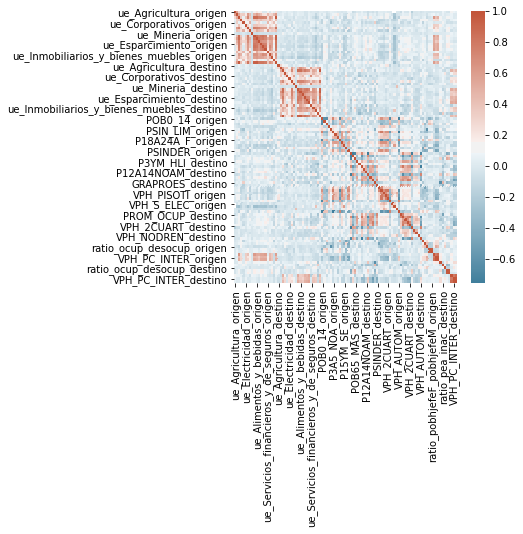

In [21]:
num_var = ageb_data.select_dtypes(include='number').columns.values

plt.figure(figsize=(5,5))
corr_matrix = ageb_data[num_var].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=False, cmap=cmap)

In [22]:
cat_var = ageb_data.select_dtypes(include='object').columns.values

# One-hot encoder for cat variables
dummies = pd.get_dummies(ageb_data[cat_var], columns = cat_var, drop_first = True)
rutas = pd.concat([ageb_data[num_var], dummies], axis = 1)
print(rutas.shape)

(406, 112)


In [23]:
# fill NaN
rutas = rutas.fillna(0)

# Fill Inf
cols =  rutas.columns
for col in cols:
    rutas.loc[rutas[col] == np.inf, col]=0


In [24]:
# scale numeric variables
scaler = StandardScaler()
rutas_scaled = scaler.fit_transform(rutas)

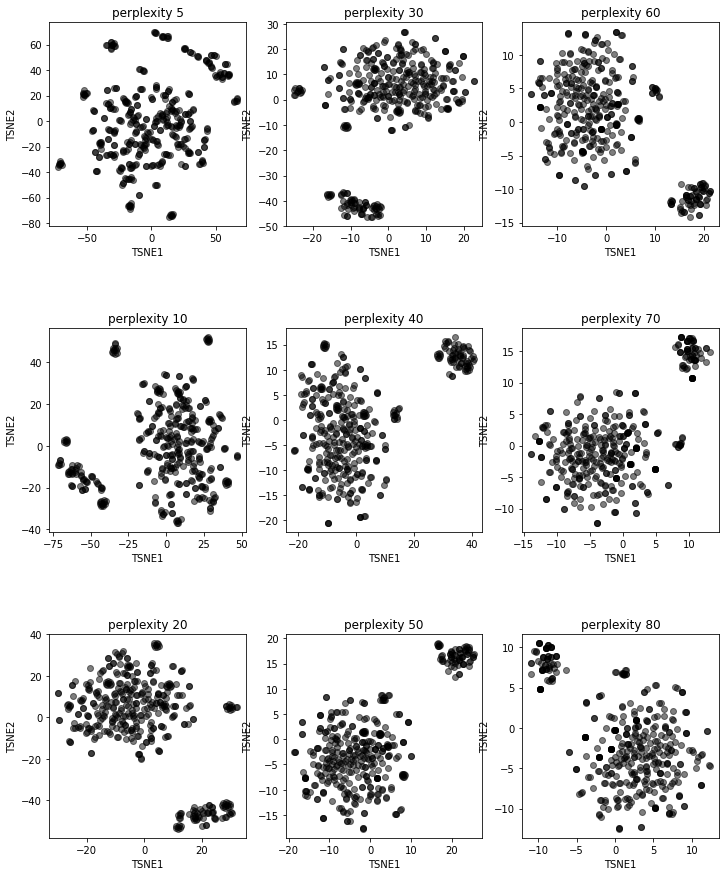

In [25]:
fig, ax = plt.subplots(3,3,figsize=(12,15))
plt.subplots_adjust(hspace=0.5)

perplexity = [5, 10, 20, 30, 40, 50, 60, 70, 80]
for i, per in enumerate(perplexity):
    tsne = TSNE(n_components=2, perplexity= per)
    tsne_components = tsne.fit_transform(rutas_scaled)
    TSNE_components = pd.DataFrame(tsne_components, index=rutas.index)
    
    ax[i%3][math.floor(i/3)].set_title(f'perplexity {per}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=0.5, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel='TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel='TSNE2')

Fitting 20 folds for each of 8 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.5s finished


Accuracy: 0.9975369458128078
Confusion Matrix: 
 [[336   0]
 [  1  69]]
{'criterion': 'gini', 'min_samples_split': 5, 'splitter': 'best'}


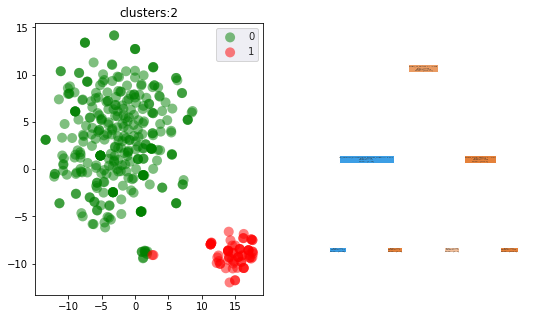

Fitting 20 folds for each of 8 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.2s finished


Accuracy: 0.9507389162561576
Confusion Matrix: 
 [[210  16   0]
 [  4 108   0]
 [  0   0  68]]
{'criterion': 'entropy', 'min_samples_split': 50, 'splitter': 'best'}


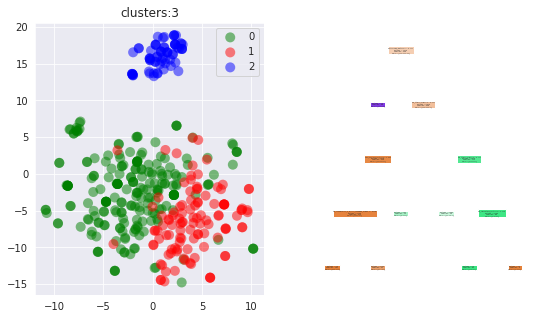

Fitting 20 folds for each of 8 candidates, totalling 160 fits


/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 17 members, which is less than n_splits=20.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.4s finished


Accuracy: 0.9236453201970444
Confusion Matrix: 
 [[159  26   0   0]
 [  5 131   0   0]
 [  0   0  68   0]
 [  0   0   0  17]]
{'criterion': 'entropy', 'min_samples_split': 50, 'splitter': 'best'}


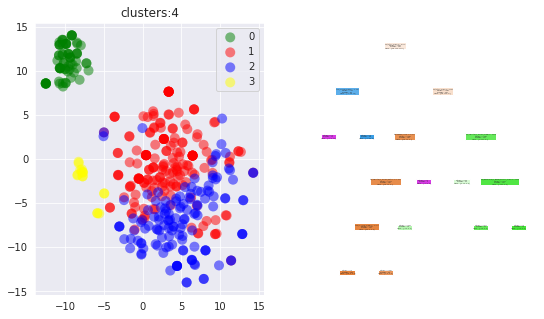

Fitting 20 folds for each of 8 candidates, totalling 160 fits


/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 12 members, which is less than n_splits=20.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.7s finished


Accuracy: 1.0
Confusion Matrix: 
 [[168   0   0   0   0]
 [  0 100   0   0   0]
 [  0   0  58   0   0]
 [  0   0   0  68   0]
 [  0   0   0   0  12]]
{'criterion': 'entropy', 'min_samples_split': 5, 'splitter': 'best'}


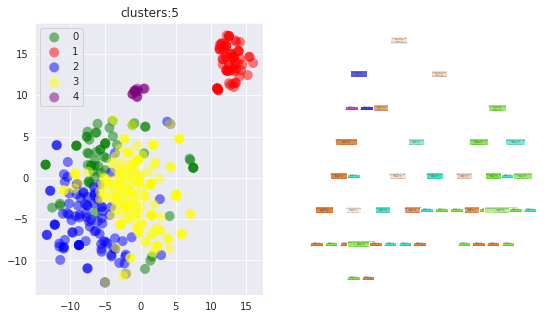

Fitting 20 folds for each of 8 candidates, totalling 160 fits


/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 12 members, which is less than n_splits=20.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.1s finished


Accuracy: 0.9433497536945813
Confusion Matrix: 
 [[136   0   0   4   0   0]
 [  3  63   1   0   0   1]
 [  2   0  48   4   0   1]
 [  6   1   0  56   0   0]
 [  0   0   0   0  68   0]
 [  0   0   0   0   0  12]]
{'criterion': 'gini', 'min_samples_split': 20, 'splitter': 'best'}


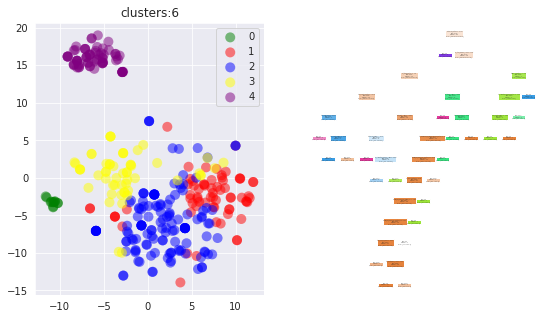

Fitting 20 folds for each of 8 candidates, totalling 160 fits


/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=20.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.2s finished


Accuracy: 0.9901477832512315
Confusion Matrix: 
 [[135   0   0   0   0   0   0]
 [  0  46   0   0   0   0   0]
 [  1   0  78   0   0   0   0]
 [  3   0   0  58   0   0   0]
 [  0   0   0   0  68   0   0]
 [  0   0   0   0   0   5   0]
 [  0   0   0   0   0   0  12]]
{'criterion': 'entropy', 'min_samples_split': 5, 'splitter': 'best'}


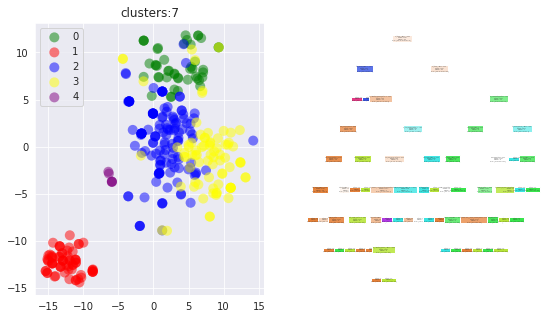

Fitting 20 folds for each of 8 candidates, totalling 160 fits


/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=20.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.3s finished


Accuracy: 0.9458128078817734
Confusion Matrix: 
 [[ 97   1   0   0   0   0   0   0]
 [  5 103   2   1   2   0   0   0]
 [  0   1  33   4   0   0   0   0]
 [  2   1   1  45   0   0   0   0]
 [  1   0   0   0  27   0   0   0]
 [  0   0   0   0   0  56   1   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0  12]]
{'criterion': 'entropy', 'min_samples_split': 20, 'splitter': 'best'}


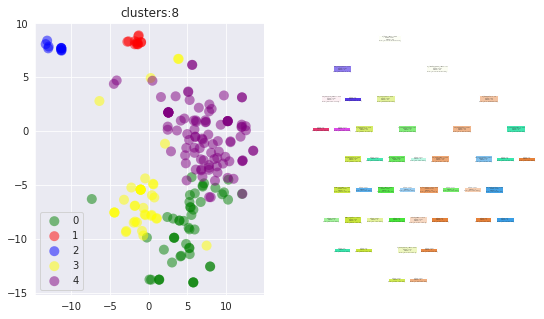

In [26]:
n_clusters = [2, 3, 4, 5, 6, 7, 8]
per = 70

kmeans_results = []
feature_imp = []
for i, num_clus in enumerate(n_clusters):
    ##### K-means
    kmeans = KMeans(random_state=0, n_clusters=num_clus)
    #Fit our model
    kmeans_results.append(kmeans.fit(rutas_scaled))
    #Find which cluster each data-point belongs to
    kmeans_clusters = kmeans.predict(rutas_scaled)
   

    ##### Decision tree
    X = rutas_scaled
    y = kmeans_clusters
    y, class_names = pd.factorize(y)
    #print('Classes:', class_names)
    classifier = DecisionTreeClassifier(random_state=50)
    #definicion de los hiperparametros que queremos probar
    hyper_param_grid = {#'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 
                        'min_samples_split': [5, 10, 20, 50],
                        'criterion':['gini', 'entropy'],
                        'splitter':['best']}
    clf  = GridSearchCV(classifier, 
                        hyper_param_grid, 
                        scoring = "accuracy",
                        cv = 20, 
                        n_jobs = -1,
                        verbose = 3)
    y_pred = clf.fit(X, y).predict(X)
    
    print("Accuracy:",metrics.accuracy_score(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    print('Confusion Matrix: \n', cm)
    clf_best = clf.best_estimator_
    print(clf.best_params_)
    
    df = vizs(rutas, rutas_scaled, kmeans_clusters, clf_best, X, y, per)
    feature_imp.append(df)

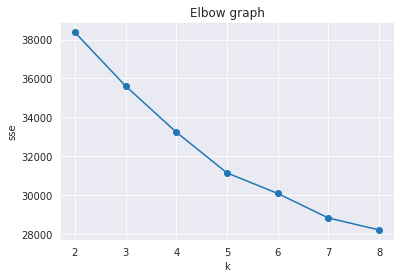

In [27]:
sses = pd.DataFrame({'k': n_clusters,
                     'sse': [round(kmeans_results[0].inertia_,2),
                             round(kmeans_results[1].inertia_,2), 
                             round(kmeans_results[2].inertia_,2),
                             round(kmeans_results[3].inertia_,2), 
                             round(kmeans_results[4].inertia_,2),
                             round(kmeans_results[5].inertia_,2),
                             round(kmeans_results[6].inertia_,2)]})

### Grafica de codo
plt.clf()
plt.plot(sses.k, sses.sse)
plt.scatter(sses.k, sses.sse)
plt.xticks(n_clusters)
plt.xlabel("k")
plt.ylabel("sse")
plt.title("Elbow graph")
plt.show()

In [28]:
feature_df = functools.reduce(lambda df1, df2: pd.concat([df1, df2],  axis=1), feature_imp)
feature_df.columns = [str(x)+'_clusters' for x in n_clusters]
feature_df['n'] = feature_df.iloc[:,1:].astype(bool).sum(axis=1)
feature_df.sort_values(['5_clusters'], ascending=False)

,2_clusters,3_clusters,4_clusters,5_clusters,6_clusters,7_clusters,8_clusters,n
ue_totales_origen,0.000000,0.381424,0.746810,0.571620,0.013113,0.480540,0.291061,6
ue_totales_destino,0.000000,0.000000,0.000000,0.137476,0.162552,0.004818,0.128927,4
tasa_hogares_origen,0.000000,0.000000,0.083185,0.059854,0.000000,0.050319,0.000000,3
ue_Esparcimiento_destino,0.000000,0.000000,0.000000,0.059187,0.000000,0.038178,0.015483,3
P18A24A_F_destino,0.000000,0.000000,0.000000,0.019116,0.000000,0.000000,0.000000,1
ue_Servicios_educativos_destino,0.000000,0.000000,0.000000,0.018847,0.000000,0.000000,0.000000,1
VPH_PC_INTER_origen,0.000000,0.000000,0.019357,0.018528,0.000000,0.003723,0.000000,3
VPH_1CUART_destino,0.000000,0.057532,0.000000,0.018124,0.000000,0.000000,0.000000,2
ue_Otros_servicios_origen,0.000000,0.000000,0.000000,0.018030,0.180585,0.000000,0.029610,3
PROM_OCUP_destino,0.005769,0.000000,0.000000,0.014355,0.000000,0.009200,0.000000,2


In [29]:
num_clus = 5

##### K-means
kmeans = KMeans(random_state = 0, n_clusters=num_clus)
#Fit our model
kmeans.fit(rutas_scaled)
#Find which cluster each data-point belongs to
kmeans_clusters = kmeans.predict(rutas_scaled)

##### Decision tree
X = rutas
y = kmeans_clusters
y, class_names = pd.factorize(y)
#print('Classes:', class_names)
clf = DecisionTreeClassifier(random_state=50, 
                             criterion= 'entropy',
                             min_samples_split= 5,
                             splitter= 'best' )

y_pred = clf.fit(X, y).predict(X)
print("Accuracy:", metrics.accuracy_score(y, y_pred))
print("F1:", metrics.f1_score(y, y_pred, average='micro'))
print("Precision:", metrics.precision_score(y, y_pred, average='micro'))

cm = confusion_matrix(y, y_pred)
print('Confusion Matrix: \n', cm)


#df = vizs(rutas, rutas_scaled, kmeans_clusters, clf, X, y, per)


Accuracy: 1.0
F1: 1.0
Precision: 1.0
Confusion Matrix: 
 [[168   0   0   0   0]
 [  0 100   0   0   0]
 [  0   0  58   0   0]
 [  0   0   0  68   0]
 [  0   0   0   0  12]]


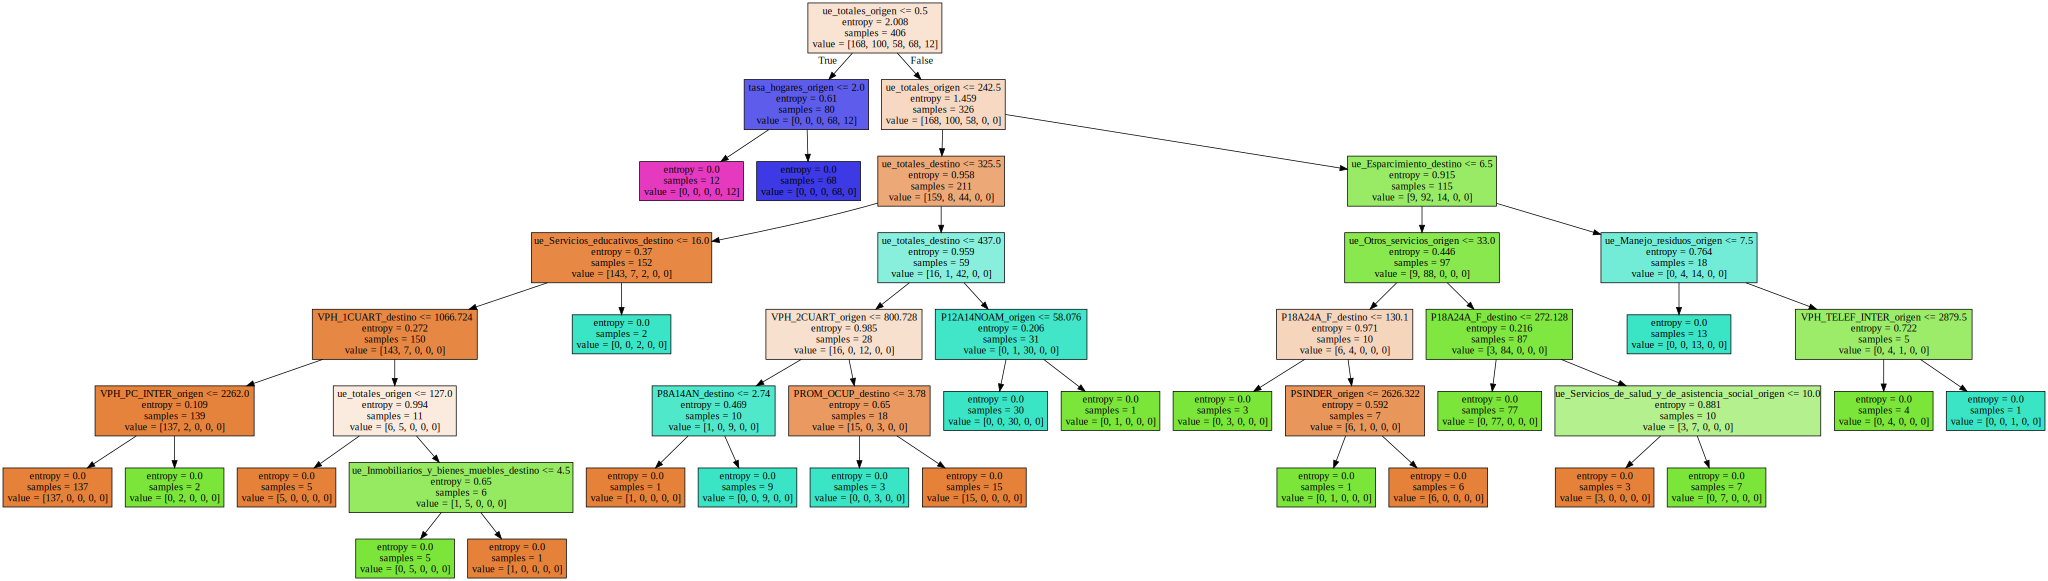

In [30]:
from sklearn.tree import export_graphviz
import graphviz

# DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=rutas.columns.to_list(),  
                           #class_names=["C0","C1", "C2"],
                           impurity=True,
                           filled=True)

# Draw graph
graph = graphviz.Source(dot_data)
graph


In [31]:
graph.render(filename='arbol_vars')
graph.render(filename='arbol_vars', format="jpg")

'arbol_vars.jpg'

In [32]:
num_clus = 5

##### K-means
kmeans = KMeans(random_state = 0, n_clusters=num_clus)
#Fit our model
kmeans.fit(rutas_scaled)
#Find which cluster each data-point belongs to
kmeans_clusters = kmeans.predict(rutas_scaled)

##### Decision tree
X = rutas_scaled
y = kmeans_clusters
y, class_names = pd.factorize(y)
#print('Classes:', class_names)
clf = DecisionTreeClassifier(random_state=50, 
                             criterion= 'entropy',
                             min_samples_split= 5,
                             splitter= 'best' )

y_pred = clf.fit(X, y).predict(X)
print("Accuracy:", metrics.accuracy_score(y, y_pred))
print("F1:", metrics.f1_score(y, y_pred, average='micro'))
print("Precision:", metrics.precision_score(y, y_pred, average='micro'))

cm = confusion_matrix(y, y_pred)
print('Confusion Matrix: \n', cm)


# DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=rutas.columns.to_list(),  
                           #class_names=["C0","C1", "C2"],
                           impurity=True,
                           filled=True)

# Draw graph
graph = graphviz.Source(dot_data)
graph
graph.render(filename='arbol_scaled')


Accuracy: 1.0
F1: 1.0
Precision: 1.0
Confusion Matrix: 
 [[168   0   0   0   0]
 [  0 100   0   0   0]
 [  0   0  58   0   0]
 [  0   0   0  68   0]
 [  0   0   0   0  12]]


'arbol_scaled.pdf'

Accuracy: 0.9605911330049262
F1: 0.9605911330049262
Precision: 0.9605911330049262
Confusion Matrix: 
 [[164   3   1   0   0]
 [  8  91   1   0   0]
 [  3   0  55   0   0]
 [  0   0   0  68   0]
 [  0   0   0   0  12]]


/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


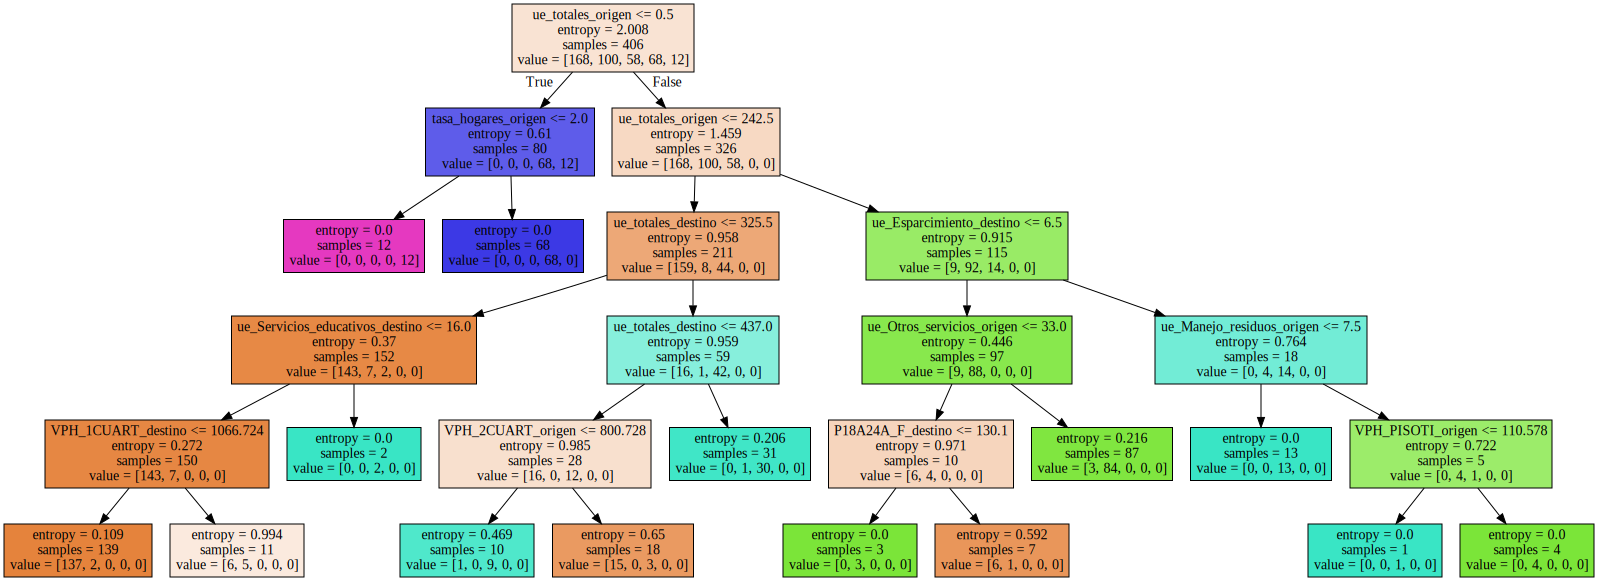

In [33]:
num_clus = 5

##### K-means
kmeans = KMeans(random_state = 0, n_clusters=num_clus)
#Fit our model
kmeans.fit(rutas_scaled)
#Find which cluster each data-point belongs to
kmeans_clusters = kmeans.predict(rutas_scaled)

##### Decision tree
X = rutas
y = kmeans_clusters
y, class_names = pd.factorize(y)
#print('Classes:', class_names)
clf = DecisionTreeClassifier(random_state=50, 
                             criterion= 'entropy',
                             min_samples_split= 5,
                             splitter= 'best',
                             max_depth= 5,
                             min_impurity_split=0.25)

y_pred = clf.fit(X, y).predict(X)
print("Accuracy:", metrics.accuracy_score(y, y_pred))
print("F1:", metrics.f1_score(y, y_pred, average='micro'))
print("Precision:", metrics.precision_score(y, y_pred, average='micro'))

cm = confusion_matrix(y, y_pred)
print('Confusion Matrix: \n', cm)


# DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=rutas.columns.to_list(),  
                           #class_names=["C0","C1", "C2"],
                           impurity=True,
                           filled=True)

# Draw graph
graph = graphviz.Source(dot_data)
graph



In [34]:
graph.render(filename='arbol_podado', format="jpg")

'arbol_podado.jpg'

### 5.
Kmeans random = 0

random = 80
{'criterion': 'entropy', 'min_samples_split': 50, 'splitter': 'best'}
depth = 6

random = 70
{'criterion': 'gini', 'min_samples_split': 5, 'splitter': 'best'}
depth = 10

random = 60
{'criterion': 'gini', 'min_samples_split': 20, 'splitter': 'best'}
depth = 8

random = 50
{'criterion': 'entropy', 'min_samples_split': 5, 'splitter': 'best'}
depth = 7

random = 45
{'criterion': 'gini', 'min_samples_split': 50, 'splitter': 'best'}
depth = 8

random = 42
{'criterion': 'entropy', 'min_samples_split': 5, 'splitter': 'best'}
depth = 7

random = 40
{'criterion': 'entropy', 'min_samples_split': 50, 'splitter': 'best'}
depth = 6

random = 30
{'criterion': 'gini', 'min_samples_split': 20, 'splitter': 'best'}
depth = 8

In [35]:
# Pego las rutas
rutas.insert(0, 'ruta', RUTAS_coord, allow_duplicates = False)
# Pego el cluster al que pertenece
rutas.insert(1, 'cluster_kmeans', kmeans_clusters, allow_duplicates = False)
rutas.shape
rutas.head(5)

,ruta,cluster_kmeans,ue_Agricultura_origen,ue_Comercio_al_por_mayor_origen,ue_Comercio_al_por_menor_origen,ue_Construccion_origen,ue_Corporativos_origen,ue_Electricidad_origen,ue_Industrias_manufactureras_origen,ue_Informacion_en_medios_masivos_origen,...,Rango_de_pobreza_(%)_origen_C1,Rango_de_pobreza_(%)_origen_C2,Rango_de_pobreza_(%)_origen_C3,Rango_de_pobreza_(%)_origen_C4,Rango_de_pobreza_(%)_origen_C5,Rango_de_pobreza_(%)_destino_C1,Rango_de_pobreza_(%)_destino_C2,Rango_de_pobreza_(%)_destino_C3,Rango_de_pobreza_(%)_destino_C4,Rango_de_pobreza_(%)_destino_C5
0,"(-98.756103515625 19.714999913710088, -98.7561...",3,0.0,3.0,89.0,1.0,0.0,0.0,16.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,"(-98.800048828125 19.21780263228372, -98.80004...",3,0.0,3.0,85.0,0.0,0.0,2.0,15.0,0.0,...,0,0,0,1,0,0,0,1,0,0
2,"(-98.82202148437499 19.69431390762537, -98.843...",3,0.0,7.0,75.0,0.0,0.0,0.0,35.0,0.0,...,0,0,1,0,0,0,0,0,1,0
3,"(-98.84399414062499 19.280035468000158, -98.84...",3,0.0,8.0,108.0,0.0,0.0,0.0,17.0,0.0,...,0,0,0,0,1,0,0,1,0,0
4,"(-98.84399414062501 19.259293812482564, -98.86...",2,0.0,16.0,226.0,0.0,0.0,0.0,35.0,2.0,...,0,0,0,1,0,0,0,0,0,0


In [38]:
rutas.to_csv('data/rutas_cluster.csv', index=False)


In [ ]:
rutas[['ruta', 'cluster_kmeans', 'VPH_1CUART_destino', 'VPH_TELEF_INTER_origen']]
rutas[rutas['cluster_kmeans']==0][['ruta', 'cluster_kmeans', 'VPH_1CUART_destino', 'VPH_TELEF_INTER_origen']].head(5)

In [ ]:
n=len(set(kmeans_clusters))
plt.figure(figsize=(9, 5))

    
datas = [[rutas[rutas['cluster_kmeans']==i][j] for j in ['VPH_1CUART_destino', 'VPH_TELEF_INTER_origen']] for i in list(set(kmeans_clusters))]
colors =  ('green', 'red', 'blue', 'yellow', 'purple')
groups = [str(i) for i in list(set(kmeans_clusters))]
    
for data, group, color in zip(datas, groups, colors):
        #print(len(data), len(color), len(group))
        # cmap=plt.get_cmap('viridis')
    plt.scatter(data[0], data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
    plt.axvline(x=1066.72, color='k', linestyle='--')
    plt.axhline(y=2648, color='k', linestyle='--')
    plt.title(f'clusters:{n}')
    plt.legend()

In [ ]:
rutas[['ue_totales_origen', 'tasa_hogares_origen']].describe()

In [ ]:
rutas[['ue_totales_origen', 'VPH_PC_INTER_origen', 'P12A14NOAM_origen', 'VPH_2CUART_origen',
       'ue_Otros_servicios_origen', 'PSINDER_origen', 
       'ue_Servicios_de_salud_y_de_asistencia_social_origen',]].describe()

In [ ]:
rutas[['ue_totales_destino', 'ue_Servicios_educativos_destino',
       'ue_Inmobiliarios_y_bienes_muebles_destino',
       'ue_Esparcimiento_destino', 'P8A14AN_destino', 'P18A24A_F_destino',
       'PROM_OCUP_destino',
       'VPH_1CUART_destino']].describe()